Load packages

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install requests
#import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import tensorflow as tf
import keras
from tensorflow.python.client import device_lib
from sklearn import preprocessing

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
#test tensorflow, remember to change the kernel
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

a = tf.constant(10)
b = tf.constant(32)
print("Result of 10 + 32 is :", sess.run(a + b))


b'Hello, TensorFlow!'
Result of 10 + 32 is : 42


In [3]:
#test keras,
import keras
from tensorflow.python.client import device_lib
print("Test if cuda is installed: ", tf.test.is_built_with_cuda())
print("Test if GPU is installed and being used by tensorflow: ", tf.test.is_gpu_available())


print("Current keras version is: ", keras.__version__)
print("Current tensorflow version is: ", tf.__version__)
print("Current devices:\n ", device_lib.list_local_devices())

Test if cuda is installed:  True
Test if GPU is installed and being used by tensorflow:  True
Current keras version is:  2.1.3
Current tensorflow version is:  1.4.1
Current devices:
  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15859636650875938457
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23154819072
locality {
  bus_id: 1
}
incarnation: 13220153985290707059
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
###############################################
#test if tensorflow is using GPU for computing
################################################
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


Load packages and use tensorflow as backend

In [5]:
############################################################ 
#importing necessary libraries for keras and scikit-learn
###############################################################
import os
import seaborn as sns

import scipy
from scipy import misc

from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras import losses
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical   

from keras import utils
from keras import losses

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.datasets import cifar10

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
#from .tqdm_callback import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.optimizers import Adam

In [14]:
######################################################
#load the wound image data
path_feature = "/media/qiwei/work/Python_playground/smart_bandage/features_train.npy"
own_x_train = np.load(path_feature)

path_label = "/media/qiwei/work/Python_playground/smart_bandage/labels_train.npy"
own_y_train = np.load(path_label)

print("Shape of training data:")
#print(own_x_train)
print(own_x_train.shape)

#print(own_y_train)
print("Shape of training labels:")
print(own_y_train.shape)
#print(own_x_train.shape[0])

from collections import Counter

print("Number of labels: ", np.unique(own_y_train, return_counts = True))

#change the labels to start with 0

own_y_train = np.subtract(own_y_train, 1)

print("Number of labels (after switch to start from 0): ", np.unique(own_y_train, return_counts = True))

Shape of training data:
(44893, 3, 70, 70)
Shape of training labels:
(44893, 1)
Number of labels:  (array([1, 2, 3, 4]), array([37317,  3846,  3282,   448]))
Number of labels (after switch to start from 0):  (array([0, 1, 2, 3]), array([37317,  3846,  3282,   448]))


(44893, 70, 70, 3)


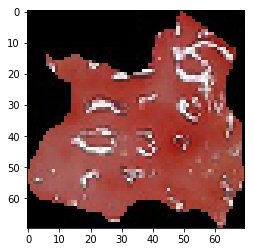

In [15]:
#############################################
# Visualize one sample
import matplotlib.pyplot as plt
own_x_train = np.swapaxes(own_x_train, 1, 3)
print(own_x_train.shape)

#print out an example of the image, use number 1205, 44400, 44700
plt.imshow(own_x_train[44400])
plt.show()

In [16]:
###############################################################################
#Preparing the dataset
#First we are going to use a Multilayer Perceptron to classify our images.
#Instead of class indices we will use one-hot encoded vectors to represent the labels of the samples. 
#We also need to vectorize the images, since the MLP will take a 14700-dimensional vector as the input. 
#When working with images, a simple way to normalize our data is to fit it within the 0 to 1 range.

# Transform label indices to one-hot encoded vectors
# use np.unique to find out the number of classes
######################################################################

num_of_class = np.unique(own_y_train).shape[0]

own_y_train_cat = to_categorical(own_y_train, num_classes=num_of_class)

# Transform images from (70,70,3) to 14700-dimensional vectors (70*70*3)
img_vector = 70*70*3

own_x_train = np.reshape(own_x_train,(own_x_train.shape[0], img_vector))

own_x_train = own_x_train.astype('float32')


# Normalization of pixel values (to [0-1] range)
own_x_train /= 255
print(own_x_train.shape)
print(own_y_train_cat.shape)
print("image vector size", img_vector)

(44893, 14700)
(44893, 4)
image vector size 14700


In [17]:
##########################################
#Feature visualization (using PCA)
##############################################
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(own_x_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
print("The explained variance ratio of PCA components", pca.explained_variance_ratio_)

The explained variance ratio of PCA components [0.506698  0.1137449]


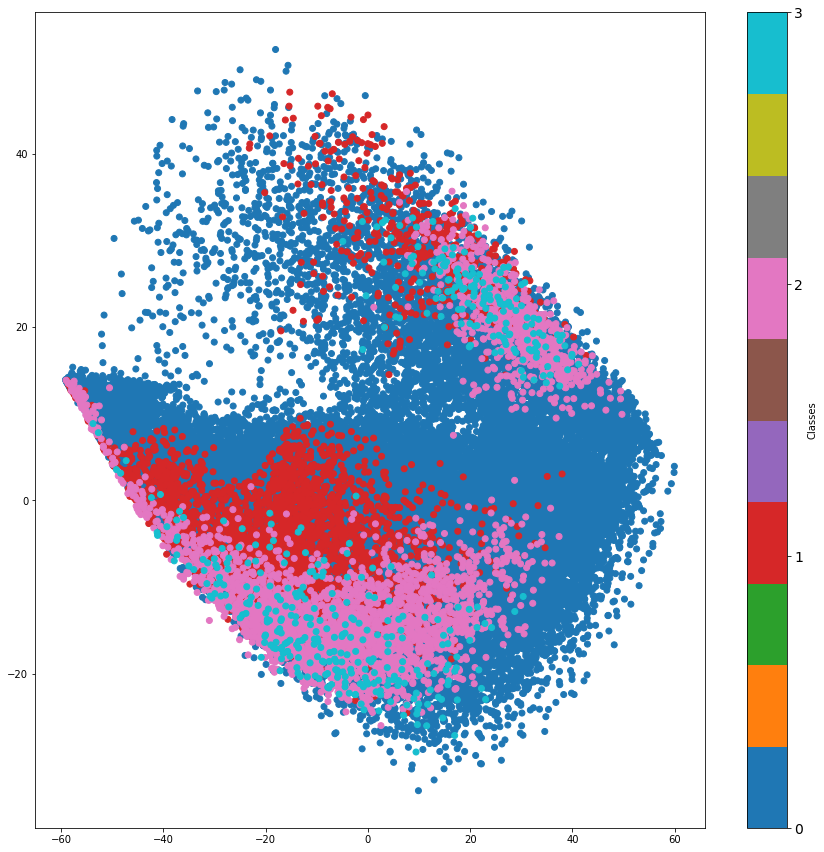

In [23]:
from matplotlib import pyplot as plt
from matplotlib import collections
X = pca.transform(own_x_train)
#print(X[:, 0])
#print(own_y_train.reshape((44893,)))

plt.figure( figsize=(15,15) )
plt.scatter( X[:, 0], X[:, 1], c=own_y_train.reshape((own_x_train.shape[0],)), cmap='tab10' )
cb = plt.colorbar(ticks = [0,1,2,3], label = "Classes")
cb.ax.tick_params(labelsize=14)
plt.show()

In [20]:
##########################################
#Feature visualization (using Tsne)
##############################################
from sklearn.manifold import TSNE
pca = decomposition.PCA(n_components = 60)
X_training_reduced = pca.fit_transform(own_x_train)
print("The sum of explained variance ratio: ", np.sum(pca.explained_variance_ratio_))

The sum of explained variance ratio:  0.89962345


In [21]:
tsne = TSNE(n_components=2)
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)
print(X_training_reduced_tsne.shape)

(44893, 2)


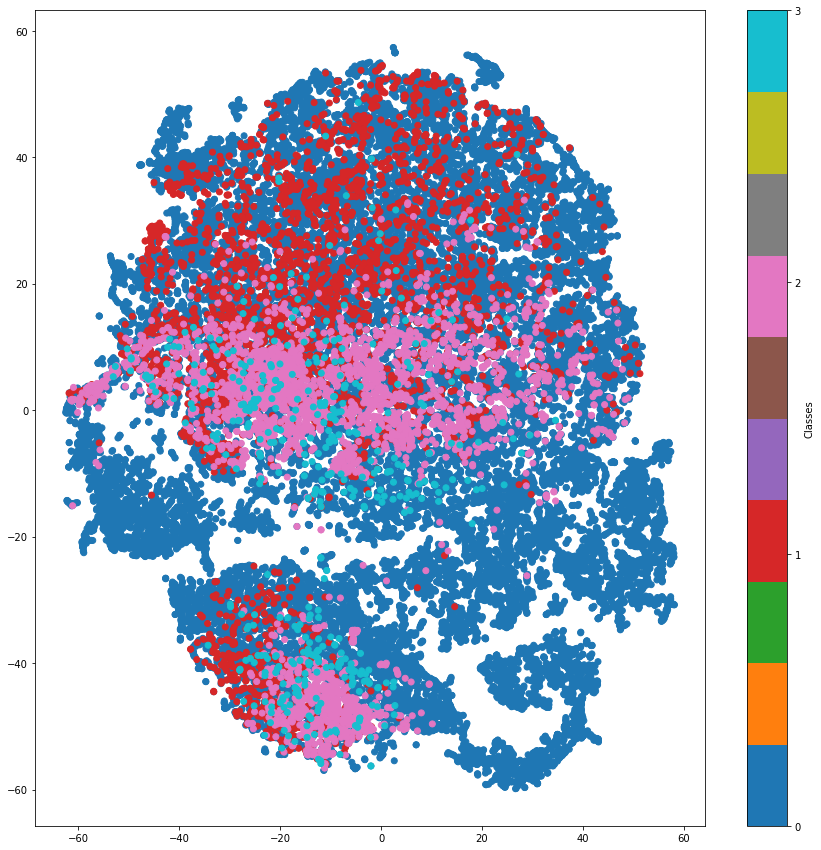

In [22]:
from matplotlib import pyplot as plt
#print(X[:, 0])
#print(own_y_train.reshape((44893,)))

plt.figure( figsize=(15,15) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=own_y_train.reshape((own_x_train.shape[0],)), cmap='tab10' )
plt.colorbar(ticks = [0,1,2,3], label = "Classes")
plt.show()

In [39]:
##################################################################################################
#MLP classifier
#The MLPs are capable of modelling complex classification problems which are typically not linearly separable.
#######################################################################################################

model2 = Sequential()
model2.add(Dense(4096, activation='relu', input_dim=img_vector))
model2.add(Dense(4096, activation='relu'))
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(num_of_class, activation='softmax'))

#optimizer options
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)

#change to adam optimizer
#adam = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

model2.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              60215296  
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total para

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='MLP_wound_classification_plot.png', show_shapes=True, show_layer_names=True)

In [41]:
#Training the MLP
#Let's train our model now! We will store the training loss values and metrics in a history object, 
#so we can visualize the training process later.
#We are going to train the model for 20 epochs, using a batch size of 1024 and a validation split of 0.1. 
#The latter means that 20% of our training data will be used as validation samples (in practice however it is advised to separate the validation data from the training data altogether).

#use stratied method to acuqire the x validation set and y validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(own_x_train, own_y_train_cat,
                                                    stratify=own_y_train, 
                                                    test_size=0.2)
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

history = model2.fit(X_train,y_train, epochs=25, batch_size=8192, verbose=2, validation_data=(X_test, y_test))

Train on 35914 samples, validate on 8979 samples
Epoch 1/25
 - 5s - loss: 0.8859 - acc: 0.8137 - val_loss: 0.6962 - val_acc: 0.8313
Epoch 2/25
 - 4s - loss: 0.6803 - acc: 0.8312 - val_loss: 0.6509 - val_acc: 0.8313
Epoch 3/25
 - 4s - loss: 0.6377 - acc: 0.8312 - val_loss: 0.6121 - val_acc: 0.8313
Epoch 4/25
 - 4s - loss: 0.5959 - acc: 0.8312 - val_loss: 0.5722 - val_acc: 0.8313
Epoch 5/25
 - 4s - loss: 0.5878 - acc: 0.8319 - val_loss: 0.8078 - val_acc: 0.8313
Epoch 6/25
 - 4s - loss: 0.6014 - acc: 0.8318 - val_loss: 0.5245 - val_acc: 0.8361
Epoch 7/25
 - 4s - loss: 0.5140 - acc: 0.8385 - val_loss: 0.5090 - val_acc: 0.8362
Epoch 8/25
 - 4s - loss: 0.5513 - acc: 0.8373 - val_loss: 0.5140 - val_acc: 0.8485
Epoch 9/25
 - 4s - loss: 0.5024 - acc: 0.8458 - val_loss: 0.4817 - val_acc: 0.8450
Epoch 10/25
 - 4s - loss: 0.4709 - acc: 0.8494 - val_loss: 0.4674 - val_acc: 0.8488
Epoch 11/25
 - 4s - loss: 0.4567 - acc: 0.8524 - val_loss: 0.4594 - val_acc: 0.8504
Epoch 12/25
 - 4s - loss: 0.4520 - a

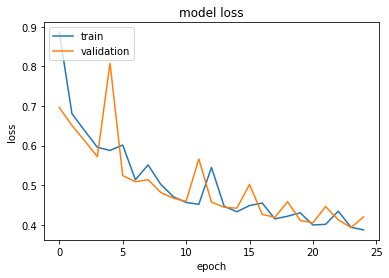

In [42]:
#With this simple function we will be able to plot our training history.
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plotLosses(history)

In [43]:
y_test_prob = model2.predict(X_test)
print(y_test_prob)

[[0.7177595  0.18977013 0.05809756 0.03437279]
 [0.3272753  0.0265083  0.6351864  0.01103003]
 [0.14273885 0.1264662  0.70506454 0.02573039]
 ...
 [0.37063664 0.09088083 0.5032966  0.03518592]
 [0.89147437 0.1011247  0.00340558 0.00399528]
 [0.3574705  0.1771409  0.4303707  0.0350179 ]]


In [44]:
##############################################################
#plot area under curve graph
#input: actual, true labels/target without one hot encoding
#       probs, predicted probabilities
#       n_classes, number of unique classes in target
#       title, input the title name for the figure
#output: a roc curve plot for multi class task
###############################################################
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

def plot_multiclass_roc_auc(actual, probs, n_classes, title = 'multi-class roc'):
    #lb = LabelBinarizer()
    #lb.fit(actual)
    #actual = lb.transform(actual)
    actual = actual
    y_prob = probs
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual[:, i], y_prob[:, i])
        #please notice the difference between auc() and roc_auc_score()
        #also auc() only works on monotonic increasing or monotonic
        #decreasing input x
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
        label='ROC curve of class {0} (area = {1:0.10f})'
            ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data using '+title)
    plt.legend(loc="lower right")
    #commented thus being able to use fig save function
    #plt.show()

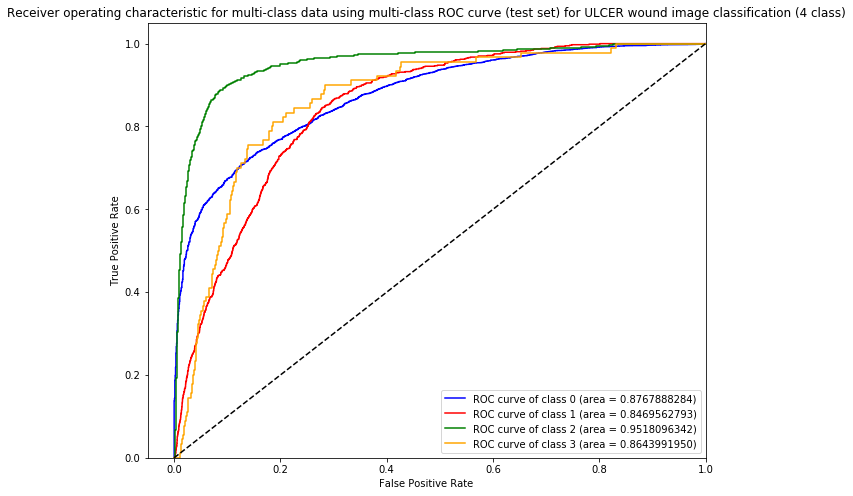

In [45]:
########################################
#print out multiclass roc auc figure
############################################

import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
plot_multiclass_roc_auc(y_test, y_test_prob, n_classes = 4, title = "multi-class ROC curve (test set) for ULCER wound image classification (4 class)")
plt.savefig('(1219)UCLCER_wound_image_ROC_curve.png')